<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Pedro_Luis_Azevedo_Costa/Aula_6_Exerc%C3%ADcio_175857.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [2]:
nome = "Pedro Luís Azevedo Costa"

print(f'Meu nome é {nome}')

Meu nome é Pedro Luís Azevedo Costa


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [4]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

## Download do CIFAR-10

In [6]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [7]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [8]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

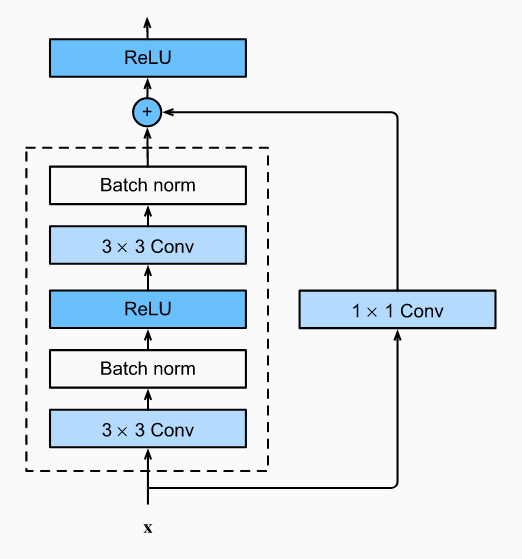

In [21]:
from torch import nn
from torch import Tensor
from torch.nn import Conv2d, ReLU, BatchNorm2d


# Consultei a documentacao do PyTorch para fazer o código abaixo.
# - https://pytorch.org/vision/0.12/_modules/torchvision/models/resnet.html

def convolution(inplanes, planes, stride, kernel_size):
    conv = Conv2d(
        in_channels = inplanes,
        out_channels = planes,
        kernel_size = kernel_size,
        stride=stride,
        bias=False,
        groups=1,
        dilation=1,
        padding=1
    )
    return conv


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.

        self.conv1 = convolution(inplanes, planes, stride, 3)
        self.conv2 = convolution(planes, planes, 1, 3)
        self.relu = ReLU(inplace=True)
        self.bn1 = BatchNorm2d(planes)
        self.bn2 = BatchNorm2d(planes)
        self.downsample = Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)



    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        x_initial = self.downsample(x)
        out += x_initial
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [22]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.7955, 0.0000, 0.1445],
          [0.0000, 0.0000, 0.8272],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.6994, 0.0000],
          [0.5927, 0.2320, 2.7501]],

         [[0.6767, 0.0000, 0.7220],
          [0.0000, 0.5992, 0.5794],
          [0.0000, 1.4828, 0.0000]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.7955, 0.0000, 0.1445],
          [0.0000, 0.0000, 0.8272],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.6994, 0.0000],
          [0.5927, 0.2320, 2.7501]],

         [[0.6767, 0.0000, 0.7220],
          [0.0000, 0.5992, 0.5794],
          [0.0000, 1.4828, 0.0000]]]], grad_fn=<ReluBackward0>)


In [11]:
height_in = 32
width_in = 32
inplanes = 64
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)
block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)
downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)
# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
out.shape

torch.Size([1, 3, 16, 16])

## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [35]:
from torch.nn import MaxPool2d, Sequential, Linear, AvgPool2d
from collections import OrderedDict

# 50, 3, 32, 32

class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.

        # Tentei adaptar algo semelhante à ResNet-18 encontrada no link abaixo:
        # https://www.researchgate.net/figure/ResNet-18-Architecture_tbl1_322476121

        self.conv_layer = Sequential(OrderedDict([
            #(50, 3, 32, 32) 
            ("conv1", MyBasicBlock(inplanes=3, planes=32, stride=1) ),
            #(50, 32, 32, 32)
            ("max_pool1", MaxPool2d(2)),
            #(50, 32, 16, 16)
            ("conv2", MyBasicBlock(inplanes=32, planes=64, stride=1) ),
            #(50, 64, 16, 16)
            ("conv3", MyBasicBlock(inplanes=64, planes=128, stride=2) ),
            #(50, 128, 8, 8)
            ("conv4", MyBasicBlock(inplanes=128, planes=256, stride=2) ),
            #(50, 256, 4, 4)
            ("conv5", MyBasicBlock(inplanes=256, planes=512, stride=2) ),
            #(50, 512, 2, 2)
            ("avg_pol1", AvgPool2d(2)),
            #(50, 512, 1, 1)
        ]))

        self.dense_layer = Sequential(OrderedDict([
            ("dense1", Linear(1*1*512, 1024)),
            ("relu1", ReLU()),
            ("dense2", Linear(1024, 10)),
        ]))

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.conv_layer(x)
        out = out.view(-1, 1*1*512)
        out = self.dense_layer(out)

        return out

## Treinamento

### Definição dos hiperparâmetros

In [13]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
def evaluation(model, loader):
    # Escreva seu código aqui.

    # O código abaixo foi inspirado no trabalho da Karen Rosero.
    n_correto = 0
    n_total = 0
    model.eval()
    with torch.no_grad():
      for x, y in tqdm(loader, total=len(loader), desc='Validation'):
        predicted = model(x.to(device))
        probs = torch.softmax(predicted, dim=1)
        max_prob = torch.argmax(probs, dim=1)
        y = y.to(device)
        #print(y.shape)
        #print(y[y == max_prob].shape[0])
        n_correto += y[y == max_prob].shape[0] 
        n_total += x.to(device).shape[0] 
        mean_accuracy = n_correto / n_total
    print(f'Accuracy: {mean_accuracy}')


### Laço de treinamento

In [36]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Validation: 100%|██████████| 200/200 [00:03<00:00, 57.13it/s]


Accuracy: 0.0973


Training: 100%|██████████| 800/800 [00:21<00:00, 38.08it/s]


Epoch: 0/19 Loss: 1.207021713256836


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.59it/s]


Accuracy: 0.5289


Training: 100%|██████████| 800/800 [00:21<00:00, 36.95it/s]


Epoch: 1/19 Loss: 1.1036522388458252


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.17it/s]


Accuracy: 0.6052


Training: 100%|██████████| 800/800 [00:21<00:00, 36.75it/s]


Epoch: 2/19 Loss: 0.8469817638397217


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.90it/s]


Accuracy: 0.703


Training: 100%|██████████| 800/800 [00:21<00:00, 38.07it/s]


Epoch: 3/19 Loss: 0.4754873216152191


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.79it/s]


Accuracy: 0.6935


Training: 100%|██████████| 800/800 [00:21<00:00, 37.96it/s]


Epoch: 4/19 Loss: 0.6482201218605042


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.12it/s]


Accuracy: 0.715


Training: 100%|██████████| 800/800 [00:20<00:00, 38.14it/s]


Epoch: 5/19 Loss: 0.5144014954566956


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.45it/s]


Accuracy: 0.6988


Training: 100%|██████████| 800/800 [00:21<00:00, 37.86it/s]


Epoch: 6/19 Loss: 0.19322961568832397


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.26it/s]


Accuracy: 0.7209


Training: 100%|██████████| 800/800 [00:21<00:00, 38.06it/s]


Epoch: 7/19 Loss: 0.18327990174293518


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.73it/s]


Accuracy: 0.7234


Training: 100%|██████████| 800/800 [00:21<00:00, 38.05it/s]


Epoch: 8/19 Loss: 0.1750083565711975


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.40it/s]


Accuracy: 0.7179


Training: 100%|██████████| 800/800 [00:21<00:00, 37.96it/s]


Epoch: 9/19 Loss: 0.38032904267311096


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.10it/s]


Accuracy: 0.7332


Training: 100%|██████████| 800/800 [00:20<00:00, 38.17it/s]


Epoch: 10/19 Loss: 0.1353563815355301


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.14it/s]


Accuracy: 0.7346


Training: 100%|██████████| 800/800 [00:20<00:00, 38.85it/s]


Epoch: 11/19 Loss: 0.09091413766145706


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.49it/s]


Accuracy: 0.7369


Training: 100%|██████████| 800/800 [00:20<00:00, 38.66it/s]


Epoch: 12/19 Loss: 0.07209630310535431


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.01it/s]


Accuracy: 0.7221


Training: 100%|██████████| 800/800 [00:20<00:00, 38.56it/s]


Epoch: 13/19 Loss: 0.004479067400097847


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.86it/s]


Accuracy: 0.7385


Training: 100%|██████████| 800/800 [00:20<00:00, 38.26it/s]


Epoch: 14/19 Loss: 0.07555412501096725


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.24it/s]


Accuracy: 0.7466


Training: 100%|██████████| 800/800 [00:20<00:00, 38.34it/s]


Epoch: 15/19 Loss: 0.007203743327409029


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.30it/s]


Accuracy: 0.7607


Training: 100%|██████████| 800/800 [00:21<00:00, 37.88it/s]


Epoch: 16/19 Loss: 0.005845325533300638


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.90it/s]


Accuracy: 0.7552


Training: 100%|██████████| 800/800 [00:21<00:00, 37.92it/s]


Epoch: 17/19 Loss: 0.004086236469447613


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.79it/s]


Accuracy: 0.7552


Training: 100%|██████████| 800/800 [00:21<00:00, 37.76it/s]


Epoch: 18/19 Loss: 0.004350294824689627


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.15it/s]


Accuracy: 0.762


Training: 100%|██████████| 800/800 [00:20<00:00, 38.35it/s]


Epoch: 19/19 Loss: 0.000659045996144414


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.69it/s]

Accuracy: 0.7588


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

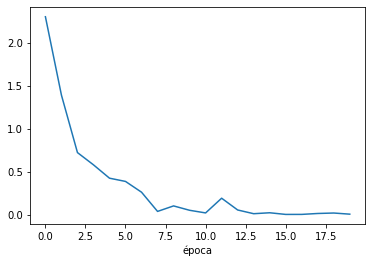

In [37]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [38]:
evaluation(model=model, loader=test_dataloader)

Validation: 100%|██████████| 200/200 [00:03<00:00, 58.41it/s]

Accuracy: 0.7552


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)